<a href="https://colab.research.google.com/github/ShobithChandran/Badge-Challenge--02/blob/main/Stock_Prediction_GRU_LSTM_GAN_WGAN-GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math

In [ ]:
## import data
df = pd.read_csv('/content/sample_data/TSLA.csv', parse_dates=['Date'])
print(df.head())
print(df.tail())
print(df.shape)
print(df.columns)

        Date   Open   High    Low  Close  Adj Close   Volume
0 2012-01-03  5.788  5.900  5.530  5.616      5.616  4640500
1 2012-01-04  5.642  5.734  5.500  5.542      5.542  3150500
2 2012-01-05  5.552  5.586  5.370  5.424      5.424  5027500
3 2012-01-06  5.440  5.558  5.282  5.382      5.382  4931500
4 2012-01-09  5.400  5.498  5.224  5.450      5.450  4485000
           Date         Open         High  ...        Close    Adj Close    Volume
2512 2021-12-27  1073.670044  1117.000000  ...  1093.939941  1093.939941  23715300
2513 2021-12-28  1109.489990  1119.000000  ...  1088.469971  1088.469971  20108000
2514 2021-12-29  1098.640015  1104.000000  ...  1086.189941  1086.189941  18718000
2515 2021-12-30  1061.329956  1095.550049  ...  1070.339966  1070.339966  15680300
2516 2021-12-31  1073.439941  1082.000000  ...  1056.780029  1056.780029  13528700

[5 rows x 7 columns]
(2517, 7)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


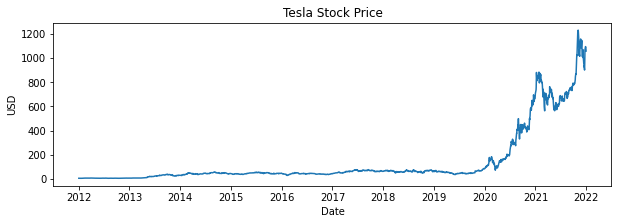

In [ ]:
# Create Tesla stock price plot
## https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/customize-dates-matplotlib-plots-python/
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(df['Date'], df['Close'], label='Tesla stock')
ax.set(xlabel="Date",
       ylabel="USD",
       title="Tesla Stock Price")
date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)
plt.show()

In [ ]:
# Calculate technical indicators
def get_technical_indicators(data):
    # Create 7 and 21 days Moving Average
    data['MA7'] = data.iloc[:,4].rolling(window=7).mean()
    data['MA21'] = data.iloc[:,4].rolling(window=21).mean()

    # Create MACD
    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA21'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA21'] - (data['20SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    # Create LogMomentum
    data['logmomentum'] = np.log(data.iloc[:,4] - 1)

    return data
T_df = get_technical_indicators(df)

In [ ]:
#Drop the first 21 rows
#For doing the fourier
dataset = T_df.iloc[20:,:].reset_index(drop=True)

In [ ]:
#Getting the Fourier transform features
def get_fourier_transfer(dataset):
    # Get the columns for doing fourier
    data_FT = dataset[['Date', 'Close']]

    close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
    fft_df = pd.DataFrame({'fft': close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

    fft_list = np.asarray(fft_df['fft'].tolist())
    fft_com_df = pd.DataFrame()
    for num_ in [3, 6, 9]:
        fft_list_m10 = np.copy(fft_list);
        fft_list_m10[num_:-num_] = 0
        fft_ = np.fft.ifft(fft_list_m10)
        fft_com = pd.DataFrame({'fft': fft_})
        fft_com['absolute of ' + str(num_) + ' comp'] = fft_com['fft'].apply(lambda x: np.abs(x))
        fft_com['angle of ' + str(num_) + ' comp'] = fft_com['fft'].apply(lambda x: np.angle(x))
        fft_com = fft_com.drop(columns='fft')
        fft_com_df = pd.concat([fft_com_df, fft_com], axis=1)

    return fft_com_df

In [ ]:
#Get Fourier features
dataset_F = get_fourier_transfer(dataset)
Final_data = pd.concat([dataset, dataset_F], axis=1)

In [ ]:
print(Final_data.head())

        Date   Open  ...  absolute of 9 comp  angle of 9 comp
0 2012-02-01  5.814  ...          472.591051        -0.026337
1 2012-02-02  5.944  ...          467.258315        -0.027150
2 2012-02-03  6.082  ...          461.908577        -0.027970
3 2012-02-06  6.220  ...          456.542728        -0.028795
4 2012-02-07  6.360  ...          451.161667        -0.029626

[5 rows x 21 columns]


In [ ]:
Final_data.to_csv("Finaldata_with_Fourier.csv", index=False)

In [ ]:
def plot_technical_indicators(dataset, last_days):
       plt.figure(figsize=(16, 10), dpi=100)
       shape_0 = dataset.shape[0]
       xmacd_ = shape_0 - last_days

       dataset = dataset.iloc[-last_days:, :]
       x_ = range(3, dataset.shape[0])
       x_ = list(dataset.index)

       # Plot first subplot
       plt.subplot(2, 1, 1)
       plt.plot(dataset['MA7'], label='MA 7', color='g', linestyle='--')
       plt.plot(dataset['Close'], label='Closing Price', color='b')
       plt.plot(dataset['MA21'], label='MA 21', color='r', linestyle='--')
       plt.plot(dataset['upper_band'], label='Upper Band', color='c')
       plt.plot(dataset['lower_band'], label='Lower Band', color='c')
       plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
       plt.title('Technical indicators for Tesla - last {} days.'.format(last_days))
       plt.ylabel('USD')
       plt.legend()

       # Plot second subplot
       plt.subplot(2, 1, 2)
       plt.title('MACD')
       plt.plot(dataset['MACD'], label='MACD', linestyle='-.')
       plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
       plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
       plt.plot(dataset['logmomentum'], label='Momentum', color='b', linestyle='-')
       
       plt.legend()
       plt.show()

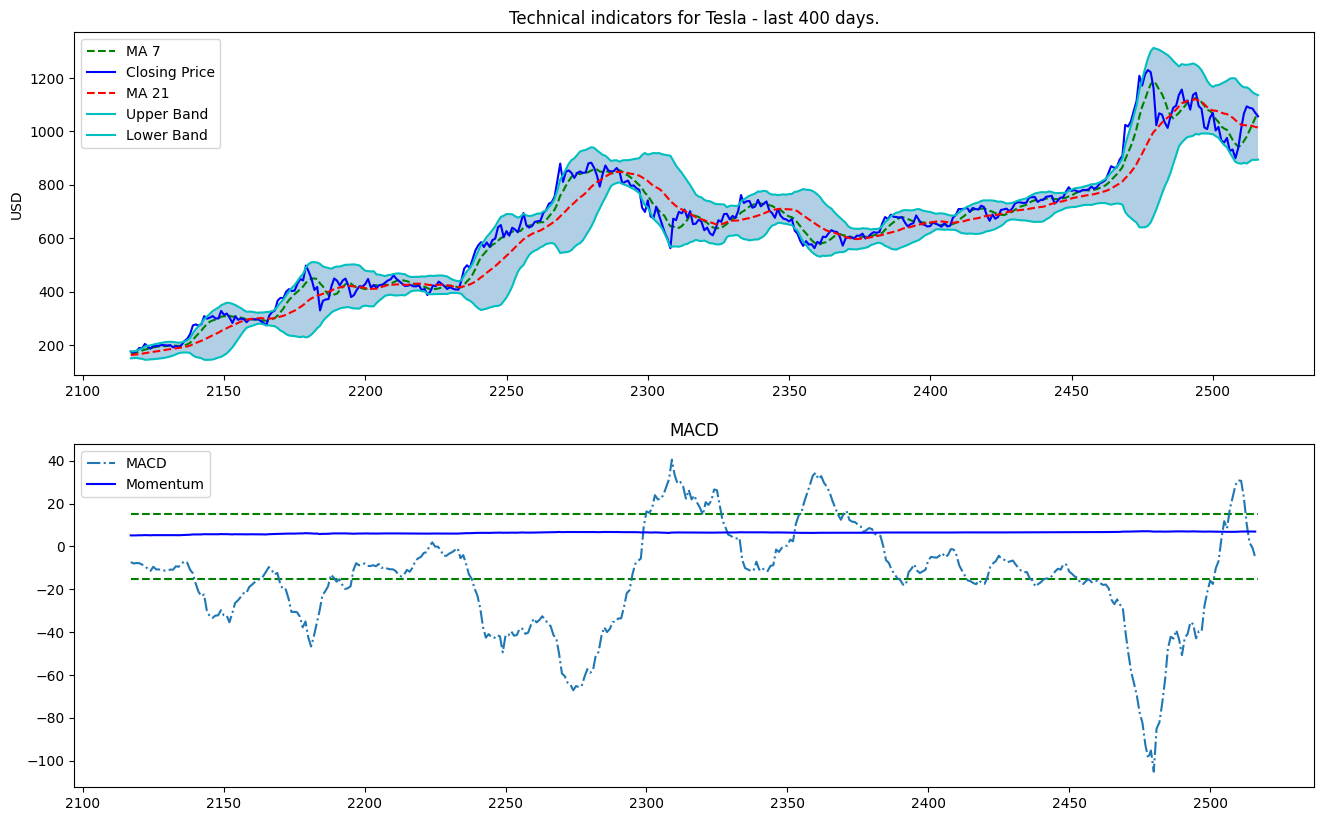

In [ ]:
plot_technical_indicators(T_df, 400)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


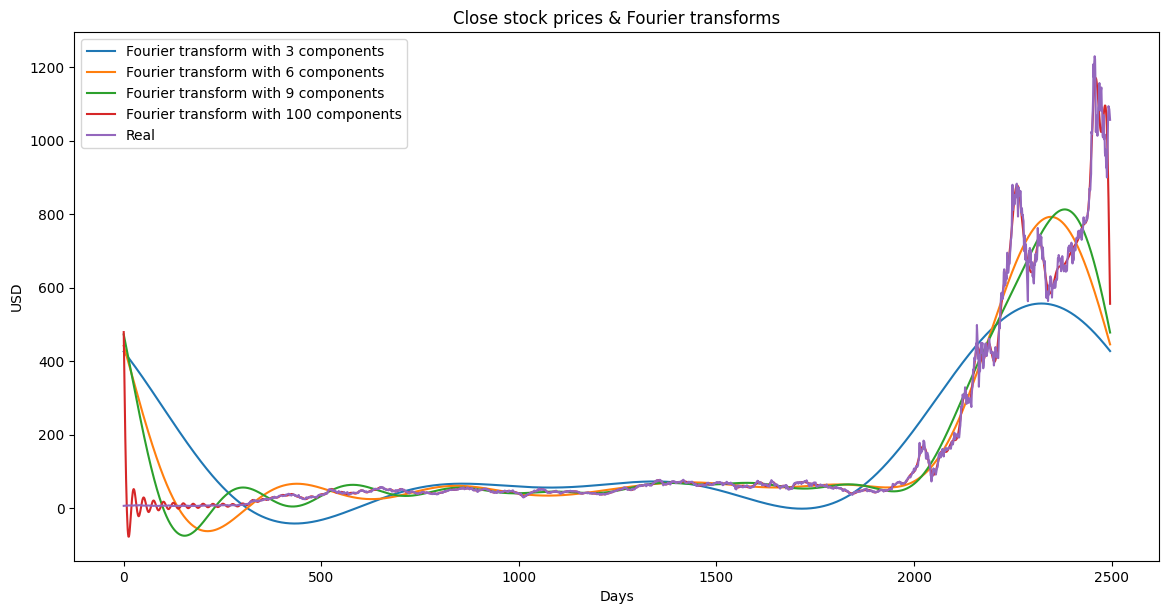

In [ ]:
def plot_Fourier(dataset):
    data_FT = dataset[['Date', 'Close']]

    close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
    fft_df = pd.DataFrame({'fft': close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

    fft_list = np.asarray(fft_df['fft'].tolist())
    plt.figure(figsize=(14, 7), dpi=100)
    fft_list = np.asarray(fft_df['fft'].tolist())
    for num_ in [3, 6, 9, 100]:
        fft_list_m10 = np.copy(fft_list);
        fft_list_m10[num_:-num_] = 0
        plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
    plt.plot(data_FT['Close'], label='Real')
    plt.xlabel('Days')
    plt.ylabel('USD')
    plt.title('Close stock prices & Fourier transforms')
    plt.legend()
    plt.show()

plot_Fourier(dataset)

In [ ]:
import os
import pandas as pd
import numpy as np
import pandas as pd
import statsmodels.api as sm
from numpy import *
from math import sqrt
from pandas import *
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pickle import dump

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# %% --------------------------------------- Load Data  -----------------------------------------------------------------
dataset = pd.read_csv('Finaldata_with_Fourier.csv', parse_dates=['Date'])
news = pd.read_csv("/content/sample_data/TSLA.csv", parse_dates=["Date"])

In [ ]:
# %% --------------------------------------- Data Preprocessing  -----------------------------------------------------------------

# Replace 0 by NA
dataset.replace(0, np.nan, inplace=True)
dataset.to_csv("dataset.csv", index=False)
# Add News data
dataset["News"] = news["Close"]


In [ ]:
# Check NA and fill them
dataset.isnull().sum()
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill(), dataset.iloc[:, 1:].bfill()]).groupby(level=0).mean()
print(dataset.columns)

# Set the date to datetime data
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'MA7',
       'MA21', 'MACD', '20SD', 'upper_band', 'lower_band', 'EMA',
       'logmomentum', 'absolute of 3 comp', 'angle of 3 comp',
       'absolute of 6 comp', 'angle of 6 comp', 'absolute of 9 comp',
       'angle of 9 comp', 'News'],
      dtype='object')


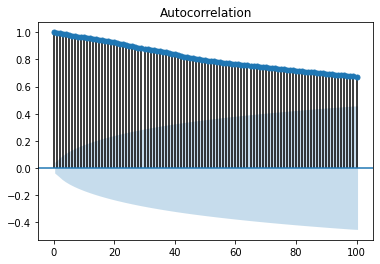

MinMaxScaler(feature_range=(-1, 1))

In [ ]:
# Get features and target
X_value = pd.DataFrame(dataset.iloc[:, :])
y_value = pd.DataFrame(dataset.iloc[:, 3])

# Autocorrelation Check
sm.graphics.tsa.plot_acf(y_value.squeeze(), lags=100)
plt.show()

# Normalized the data
X_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaler.fit(X_value)
y_scaler.fit(y_value)

In [ ]:
X_scale_dataset = X_scaler.fit_transform(X_value)
y_scale_dataset = y_scaler.fit_transform(y_value)

dump(X_scaler, open('X_scaler.pkl', 'wb'))
dump(y_scaler, open('y_scaler.pkl', 'wb'))

In [ ]:
# Reshape the data
'''Set the data input steps and output steps, 
    we use 30 days data to predict 1 day price here, 
    reshape it to (None, input_step, number of features) used for LSTM input'''
n_steps_in = 3
n_features = X_value.shape[1]
n_steps_out = 1

In [ ]:
# Get X/y dataset
def get_X_y(X_data, y_data):
    X = list()
    y = list()
    yc = list()

    length = len(X_data)
    for i in range(0, length, 1):
        X_value = X_data[i: i + n_steps_in][:, :]
        y_value = y_data[i + n_steps_in: i + (n_steps_in + n_steps_out)][:, 0]
        yc_value = y_data[i: i + n_steps_in][:, :]
        if len(X_value) == 3 and len(y_value) == 1:
            X.append(X_value)
            y.append(y_value)
            yc.append(yc_value)

    return np.array(X), np.array(y), np.array(yc)


In [ ]:
# get the train test predict index
def predict_index(dataset, X_train, n_steps_in, n_steps_out):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[n_steps_in : X_train.shape[0] + n_steps_in + n_steps_out - 1, :].index
    np.save('train_predict_index.npy', train_predict_index)
    test_predict_index = dataset.iloc[X_train.shape[0] + n_steps_in:, :].index
    np.save('test_predict_index.npy', test_predict_index)

    return train_predict_index, test_predict_index

# Split train/test dataset
def split_train_test(data):
    train_size = round(len(X) * 0.7)
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [ ]:
# Get data and check shape
X, y, yc = get_X_y(X_scale_dataset, y_scale_dataset)
X_train, X_test, = split_train_test(X)
y_train, y_test, = split_train_test(y)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(dataset, X_train, n_steps_in, n_steps_out)
# %% --------------------------------------- Save dataset -----------------------------------------------------------------
print('X shape: ', X.shape)
print('y shape: ', y.shape)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('y_c_train shape: ', yc_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)
print('y_c_test shape: ', yc_test.shape)
print('index_train shape:', index_train.shape)
print('index_test shape:', index_test.shape)


np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)
np.save("yc_train.npy", yc_train)
np.save("yc_test.npy", yc_test)
np.save('index_train.npy', index_train)
np.save('index_test.npy', index_test)



X shape:  (2494, 3, 21)
y shape:  (2494, 1)
X_train shape:  (1746, 3, 21)
y_train shape:  (1746, 1)
y_c_train shape:  (1746, 3, 1)
X_test shape:  (748, 3, 21)
y_test shape:  (748, 1)
y_c_test shape:  (748, 3, 1)
index_train shape: (1746,)
index_test shape: (748,)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from numpy import *
from math import sqrt
from pandas import *
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional
from tensorflow.keras.layers import BatchNormalization, Embedding, TimeDistributed, LeakyReLU
from tensorflow.keras.layers import GRU, LSTM
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot
from pickle import load

In [ ]:
# Load data
X_train = np.load("X_train.npy", allow_pickle=True)
y_train = np.load("y_train.npy", allow_pickle=True)
X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)
yc_train = np.load("yc_train.npy", allow_pickle=True)
yc_test = np.load("yc_test.npy", allow_pickle=True)

In [ ]:
# Parameters
LR = 0.0001
BATCH_SIZE = 128
N_EPOCH = 100

input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_dim = y_train.shape[1]

In [ ]:
def basic_GRU(input_dim, output_dim, feature_size) -> tf.keras.models.Model:
    model = Sequential()
    model.add(GRU(units=128, return_sequences = True, input_shape=(input_dim, feature_size))) 
    model.add(GRU(units=64, input_shape=(input_dim, feature_size)))
    #model.add(Dense(128))
    model.add(Dense(32))
    # model.add(Dense(32))
    model.add(Dense(units=output_dim))
    model.compile(optimizer=Adam(lr=LR), loss='mse')
    history = model.fit(X_train, y_train, epochs=N_EPOCH, batch_size=BATCH_SIZE, validation_data=(X_test, y_test),
                        verbose=2, shuffle=False)

    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()

    return model

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
14/14 - 6s - loss: 0.2818 - val_loss: 0.0598 - 6s/epoch - 461ms/step
Epoch 2/100
14/14 - 0s - loss: 0.0227 - val_loss: 0.0175 - 269ms/epoch - 19ms/step
Epoch 3/100
14/14 - 0s - loss: 0.0088 - val_loss: 0.0175 - 289ms/epoch - 21ms/step
Epoch 4/100
14/14 - 0s - loss: 0.0013 - val_loss: 0.0190 - 278ms/epoch - 20ms/step
Epoch 5/100
14/14 - 0s - loss: 0.0013 - val_loss: 0.0190 - 285ms/epoch - 20ms/step
Epoch 6/100
14/14 - 0s - loss: 0.0011 - val_loss: 0.0179 - 265ms/epoch - 19ms/step
Epoch 7/100
14/14 - 0s - loss: 7.1720e-04 - val_loss: 0.0181 - 281ms/epoch - 20ms/step
Epoch 8/100
14/14 - 0s - loss: 6.0950e-04 - val_loss: 0.0182 - 275ms/epoch - 20ms/step
Epoch 9/100
14/14 - 0s - loss: 6.0847e-04 - val_loss: 0.0181 - 253ms/epoch - 18ms/step
Epoch 10/100
14/14 - 0s - loss: 5.3744e-04 - val_loss: 0.0181 - 322ms/epoch - 23ms/step
Epoch 11/100
14/14 - 0s - loss: 4.8445e-04 - val_loss: 0.0182 - 280ms/epoch - 20ms/step
Epoch 12/100
14/14 - 0s - loss: 4.4806e-04 - val_loss: 0.0182 - 290

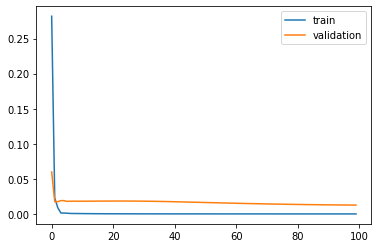

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 3, 128)            57984     
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 97,345
Trainable params: 97,345
Non-trainable params: 0
_________________________________________________________________
None
0.11226933810088194


In [ ]:
model = basic_GRU(input_dim, output_dim, feature_size)
print(model.summary())
model.save('GRU_30to3.h5')

yhat = model.predict(X_test, verbose=0)
# print(yhat)

rmse = sqrt(mean_squared_error(y_test, yhat))
print(rmse)

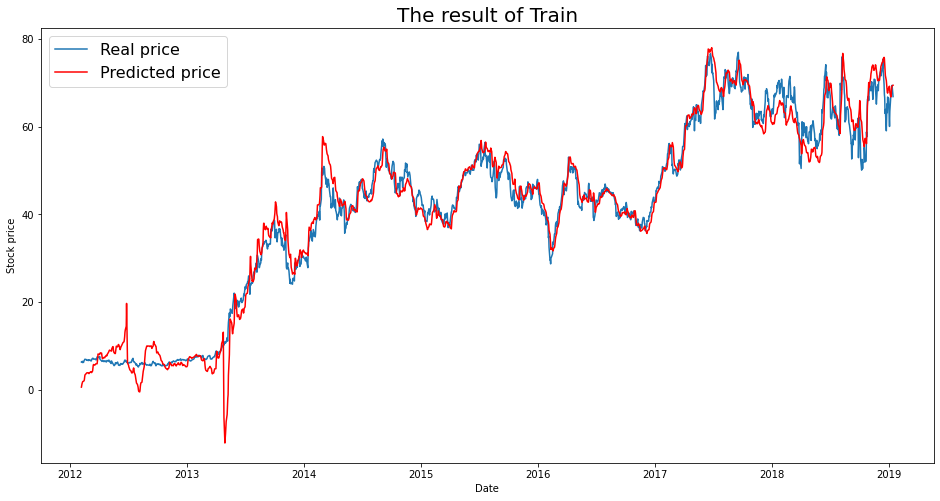

-- Train RMSE --  3.4175416440800648
----- Train_RMSE_GRU ----- 3.4175416440800648
            predicted_price  predicted_price  ...  predicted_price  predicted_mean
2021-12-17              NaN              NaN  ...              NaN      875.043579
2021-12-20              NaN              NaN  ...              NaN      873.128906
2021-12-21              NaN              NaN  ...              NaN      865.700378
2021-12-22              NaN              NaN  ...              NaN      854.228882
2021-12-23              NaN              NaN  ...              NaN      853.308655
2021-12-27              NaN              NaN  ...              NaN      864.353943
2021-12-28              NaN              NaN  ...              NaN      885.199097
2021-12-29              NaN              NaN  ...              NaN      902.501587
2021-12-30              NaN              NaN  ...              NaN      913.338440
2021-12-31              NaN              NaN  ...       915.389648      915.389648

[10

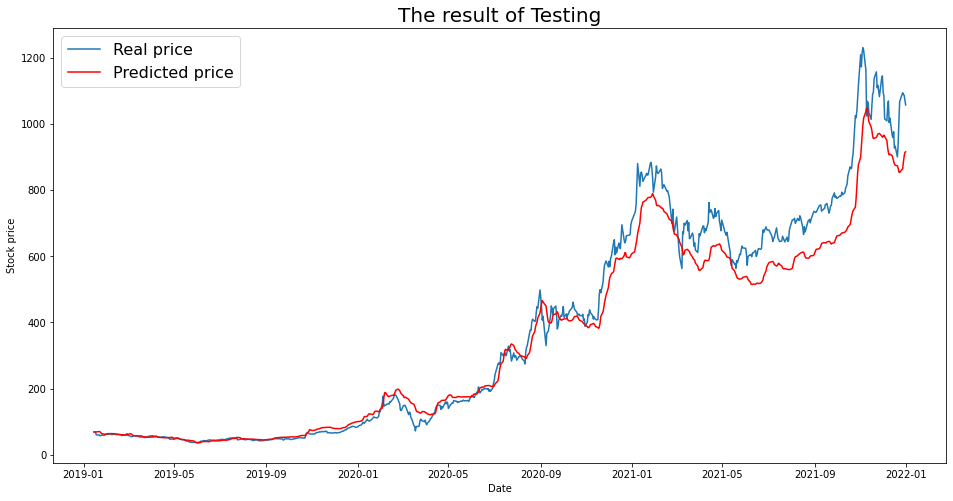

-- Test RMSE --  68.74756838426974
----- Test_RMSE_GRU ----- 68.74756838426974


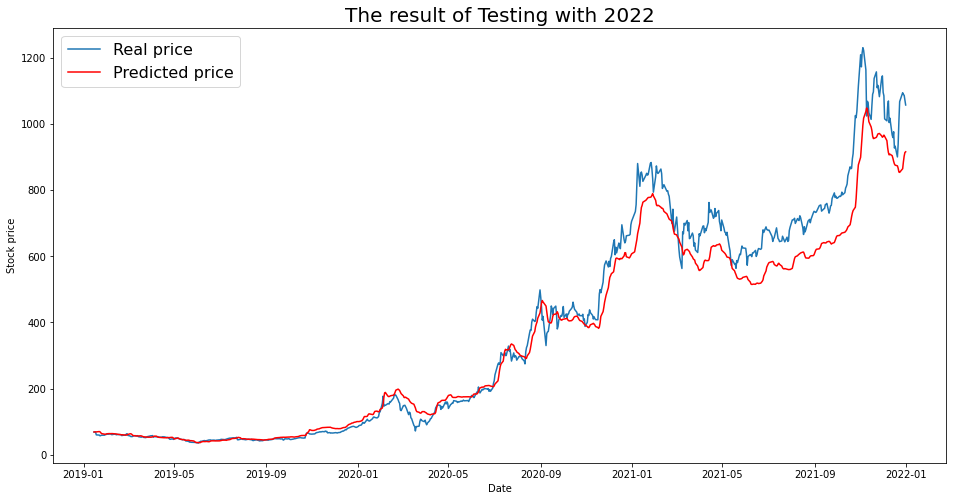

----- Test_RMSE_GRU_with2022 ----- 68.74756689557339


In [ ]:
# %% --------------------------------------- Plot the result  -----------------------------------------------------------------
## TRAIN DATA
def plot_traindataset_result(X_train, y_train):
    train_yhat = model.predict(X_train, verbose=0)

    y_scaler = load(open('y_scaler.pkl', 'rb'))
    train_predict_index = np.load("train_predict_index.npy", allow_pickle=True)

    rescaled_real_y = y_scaler.inverse_transform(y_train)
    rescaled_predicted_y = y_scaler.inverse_transform(train_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=train_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=train_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Train", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis=1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- Train RMSE -- ', RMSE)

    return RMSE


# %% --------------------------------------- Plot the result  -----------------------------------------------------------------
def plot_testdataset_result(X_test, y_test):

    test_yhat = model.predict(X_test, verbose=0)
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = np.load("test_predict_index.npy", allow_pickle=True)

    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(test_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    Input_Before = '2022-01-01'
    predict_result = predict_result.loc[predict_result.index < Input_Before]
    real_price = real_price.loc[real_price.index < Input_Before]

    print(predict_result.tail(10))

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Testing", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- Test RMSE -- ', RMSE)

    return RMSE

def plot_testdataset_with2022_result(X_test, y_test):


    test_yhat = model.predict(X_test, 1, verbose=0)

    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = np.load("test_predict_index.npy", allow_pickle=True)

    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(test_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Testing with 2022", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    

    return RMSE

train_RMSE = plot_traindataset_result(X_train, y_train)
print("----- Train_RMSE_GRU -----", train_RMSE)

test_RMSE = plot_testdataset_result(X_test, y_test)
print("----- Test_RMSE_GRU -----", test_RMSE)

test_with2022_RMSE = plot_testdataset_with2022_result(X_test, y_test)
print("----- Test_RMSE_GRU_with2022 -----", test_with2022_RMSE)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow

from numpy import *
from math import sqrt
from pandas import *
from datetime import datetime, timedelta

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional
from tensorflow.keras.layers import BatchNormalization, Embedding, TimeDistributed, LeakyReLU
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot
from pickle import load

In [ ]:
X_train = np.load("X_train.npy", allow_pickle=True)
y_train = np.load("y_train.npy", allow_pickle=True)
X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)
yc_train = np.load("yc_train.npy", allow_pickle=True)
yc_test = np.load("yc_test.npy", allow_pickle=True)

In [ ]:
#Parameters
LR = 0.001
BATCH_SIZE = 128
N_EPOCH = 100

input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_dim = y_train.shape[1]

In [ ]:
def basic_lstm(input_dim, feature_size):
    model = Sequential()
    model.add(Bidirectional(LSTM(units= 128), input_shape=(input_dim, feature_size)))
    model.add(Dense(64))
    model.add(Dense(units=output_dim))
    model.compile(optimizer=Adam(lr = LR), loss='mse')
    history = model.fit(X_train, y_train, epochs=N_EPOCH, batch_size=BATCH_SIZE, validation_data=(X_test, y_test),
                        verbose=2, shuffle=False)

    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()

    return model

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
14/14 - 5s - loss: 0.1017 - val_loss: 0.0369 - 5s/epoch - 380ms/step
Epoch 2/100
14/14 - 0s - loss: 0.0214 - val_loss: 0.0258 - 364ms/epoch - 26ms/step
Epoch 3/100
14/14 - 0s - loss: 0.0051 - val_loss: 0.0171 - 391ms/epoch - 28ms/step
Epoch 4/100
14/14 - 0s - loss: 0.0020 - val_loss: 0.0127 - 406ms/epoch - 29ms/step
Epoch 5/100
14/14 - 0s - loss: 9.5269e-04 - val_loss: 0.0115 - 367ms/epoch - 26ms/step
Epoch 6/100
14/14 - 0s - loss: 0.0011 - val_loss: 0.0127 - 376ms/epoch - 27ms/step
Epoch 7/100
14/14 - 0s - loss: 0.0025 - val_loss: 0.0135 - 347ms/epoch - 25ms/step
Epoch 8/100
14/14 - 0s - loss: 0.0013 - val_loss: 0.0124 - 325ms/epoch - 23ms/step
Epoch 9/100
14/14 - 0s - loss: 5.1244e-04 - val_loss: 0.0105 - 356ms/epoch - 25ms/step
Epoch 10/100
14/14 - 0s - loss: 4.2917e-04 - val_loss: 0.0087 - 381ms/epoch - 27ms/step
Epoch 11/100
14/14 - 0s - loss: 2.5611e-04 - val_loss: 0.0076 - 368ms/epoch - 26ms/step
Epoch 12/100
14/14 - 0s - loss: 1.1447e-04 - val_loss: 0.0070 - 354ms/e

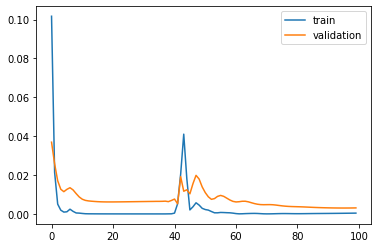

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 256)              153600    
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 170,113
Trainable params: 170,113
Non-trainable params: 0
_________________________________________________________________
None
0.05579409784915584


In [ ]:
model = basic_lstm(input_dim, feature_size)
model.save('LSTM_3to1.h5')
print(model.summary())

yhat = model.predict(X_test, verbose=0)
#print(yhat)

rmse = sqrt(mean_squared_error(y_test, yhat))
print(rmse)

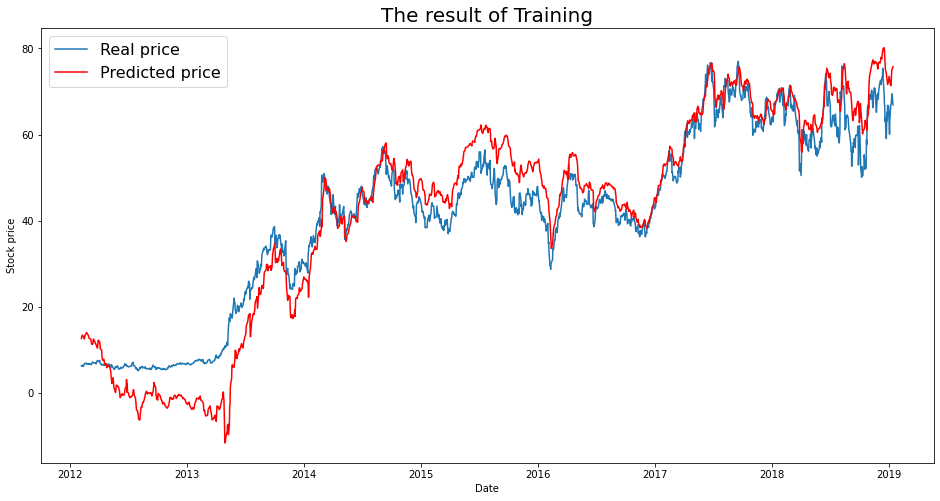

-- Train RMSE --  6.188842577212682
----- Train_RMSE_LSTM ----- 6.188842577212682
            predicted_price  predicted_price  ...  predicted_price  predicted_mean
2021-12-17              NaN              NaN  ...              NaN      989.960876
2021-12-20              NaN              NaN  ...              NaN      986.317383
2021-12-21              NaN              NaN  ...              NaN      976.444397
2021-12-22              NaN              NaN  ...              NaN      967.344116
2021-12-23              NaN              NaN  ...              NaN      968.789551
2021-12-27              NaN              NaN  ...              NaN      984.589050
2021-12-28              NaN              NaN  ...              NaN     1008.613953
2021-12-29              NaN              NaN  ...              NaN     1031.871094
2021-12-30              NaN              NaN  ...              NaN     1047.433472
2021-12-31              NaN              NaN  ...      1050.428223     1050.428223

[10 

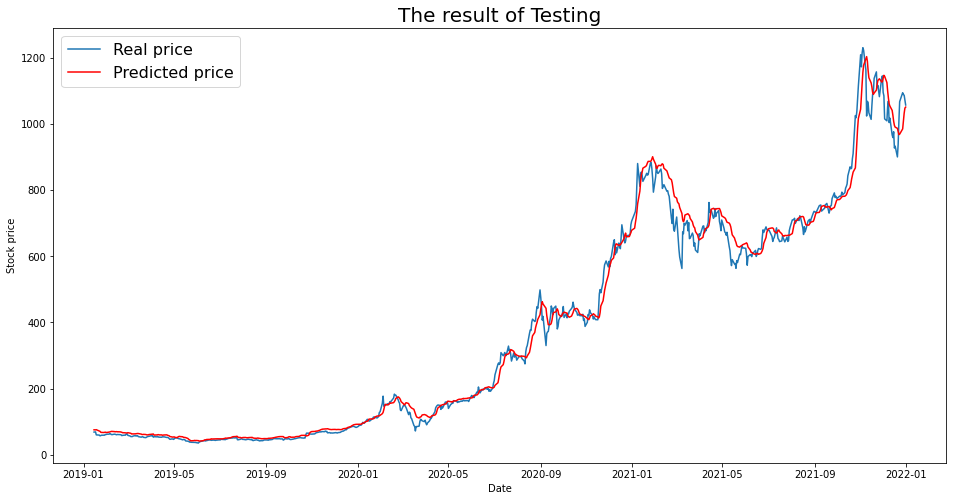

-- Test RMSE --  34.16523679716093
----- Test_RMSE_LSTM ----- 34.16523679716093


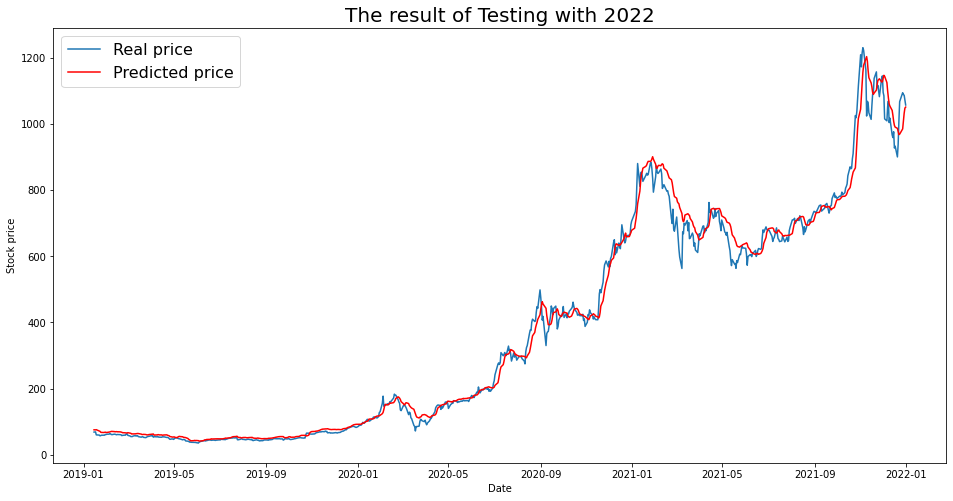

----- Test_RMSE_LSTM_with2022 ----- 34.165237498258065


In [ ]:
# %% --------------------------------------- Plot the TRAIN result  -----------------------------------------------------------------
## TRAIN DATA
def plot_traindataset_result(X_train, y_train):


    train_yhat = model.predict(X_train, verbose=0)

    X_scaler = load(open('X_scaler.pkl', 'rb'))
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    train_predict_index = np.load("train_predict_index.npy", allow_pickle=True)

    rescaled_real_y = y_scaler.inverse_transform(y_train)
    rescaled_predicted_y = y_scaler.inverse_transform(train_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=train_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)
    #
    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=train_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)
    #
    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Training", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- Train RMSE -- ', RMSE)

    return RMSE


# %% --------------------------------------- Plot the TEST result  -----------------------------------------------------------------
def plot_testdataset_result(X_test, y_test):

    test_yhat = model.predict(X_test, verbose=0)
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = np.load("test_predict_index.npy", allow_pickle=True)

    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(test_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    Input_Before = '2022-01-01'
    predict_result = predict_result.loc[predict_result.index < Input_Before]
    real_price = real_price.loc[real_price.index < Input_Before]

    print(predict_result.tail(10))

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Testing", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- Test RMSE -- ', RMSE)

    return RMSE

def plot_testdataset_with2022_result(X_test, y_test):


    test_yhat = model.predict(X_test, 1, verbose=0)

    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = np.load("test_predict_index.npy", allow_pickle=True)

    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(test_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Testing with 2022", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    

    return RMSE

train_RMSE = plot_traindataset_result(X_train, y_train)
print("----- Train_RMSE_LSTM -----", train_RMSE)

test_RMSE = plot_testdataset_result(X_test, y_test)
print("----- Test_RMSE_LSTM -----", test_RMSE)

test_with2022_RMSE = plot_testdataset_with2022_result(X_test, y_test)
print("----- Test_RMSE_LSTM_with2022 -----", test_with2022_RMSE)

In [ ]:
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
#from main.feature import get_all_features
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from pickle import load
from sklearn.metrics import mean_squared_error


In [ ]:
X_train = np.load("X_train.npy", allow_pickle=True)
y_train = np.load("y_train.npy", allow_pickle=True)
X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)
yc_train = np.load("yc_train.npy", allow_pickle=True)
yc_test = np.load("yc_test.npy", allow_pickle=True)

In [ ]:
def make_generator_model(input_dim, output_dim, feature_size) -> tf.keras.models.Model:

    model = Sequential()
    model.add(LSTM(units=1024, return_sequences = True, input_shape=(input_dim, feature_size),
                  recurrent_dropout=0.2))
    model.add(LSTM(units=512, return_sequences = True, recurrent_dropout=0.2)) 
    model.add(LSTM(units=256, recurrent_dropout=0.2)) 
    model.add(Dense(128))
    # model.add(Dense(128))
    model.add(Dense(64))
    #model.add(Dense(16))
    model.add(Dense(units=output_dim))
    return model

def make_discriminator_model():

    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(32, input_shape=(4, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(128, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Flatten())
    cnn_net.add(Dense(220, use_bias=False))
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))
    cnn_net.add(Dense(1, activation='sigmoid'))
    return cnn_net

In [ ]:
model = make_discriminator_model()
model.save('GAN_3to1.h5')
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 32)             128       
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             10304     
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 128)            41088     
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 220)               28160     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 220)               0         
                                                                 
 dense_5 (Dense)             (None, 220)              

In [ ]:
class GAN:
    def __init__(self, generator, discriminator, opt):
        self.opt = opt
        self.lr = opt["lr"]
        self.generator = generator
        self.discriminator = discriminator
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.generator_optimizer = tf.keras.optimizers.Adam(lr=self.lr)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(lr=self.lr)
        self.batch_size = self.opt['bs']
        self.checkpoint_dir = '../training_checkpoints'
        self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")
        self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                              discriminator_optimizer=self.discriminator_optimizer,
                                              generator=self.generator,
                                              discriminator=self.discriminator)
    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss
    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)
    @tf.function
    def train_step(self, real_x, real_y, yc):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_data = self.generator(real_x, training=True)
            generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
            d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
            real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
            d_real_input = tf.concat([real_y_reshape, yc], axis=1)

            # Reshape for MLP
            # d_fake_input = tf.reshape(d_fake_input, [d_fake_input.shape[0], d_fake_input.shape[1]])
            # d_real_input = tf.reshape(d_real_input, [d_real_input.shape[0], d_real_input.shape[1]])

            real_output = self.discriminator(d_real_input, training=True)
            fake_output = self.discriminator(d_fake_input, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(
            zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': gen_loss}
    def train(self, real_x, real_y, yc, opt):
        train_hist = {}
        train_hist['D_losses'] = []
        train_hist['G_losses'] = []
        train_hist['per_epoch_times'] = []
        train_hist['total_ptime'] = []

        epochs = opt["epoch"]
        for epoch in range(epochs):
            start = time.time()

            real_price, fake_price, loss = self.train_step(real_x, real_y, yc)

            G_losses = []
            D_losses = []

            Real_price = []
            Predicted_price = []

            D_losses.append(loss['d_loss'].numpy())
            G_losses.append(loss['g_loss'].numpy())

            Predicted_price.append(fake_price.numpy())
            Real_price.append(real_price.numpy())

            # Save the model every 15 epochs
            if (epoch + 1) % 15 == 0:
                tf.keras.models.save_model(generator, 'gen_model_3_1_%d.h5' % epoch)
                self.checkpoint.save(file_prefix=self.checkpoint_prefix + f'-{epoch}')
                print('epoch', epoch + 1, 'd_loss', loss['d_loss'].numpy(), 'g_loss', loss['g_loss'].numpy())
            # print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
            # For printing loss
            epoch_end_time = time.time()
            per_epoch_ptime = epoch_end_time - start
            train_hist['D_losses'].append(D_losses)
            train_hist['G_losses'].append(G_losses)
            train_hist['per_epoch_times'].append(per_epoch_ptime)

        # Reshape the predicted result & real
        Predicted_price = np.array(Predicted_price)
        Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
        Real_price = np.array(Real_price)
        Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

        plt.plot(train_hist['D_losses'], label='D_loss')
        plt.plot(train_hist['G_losses'], label='G_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(
            Real_price)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


epoch 15 d_loss 1.3876793 g_loss 0.6849154
epoch 30 d_loss 1.3621142 g_loss 0.71368355
epoch 45 d_loss 1.3886523 g_loss 0.697045
epoch 60 d_loss 1.3712231 g_loss 0.7110465
epoch 75 d_loss 1.3773246 g_loss 0.6901205
epoch 90 d_loss 1.3860234 g_loss 0.69437087
epoch 105 d_loss 1.3818992 g_loss 0.6995107
epoch 120 d_loss 1.3831339 g_loss 0.6942194
epoch 135 d_loss 1.3819906 g_loss 0.6955004
epoch 150 d_loss 1.385355 g_loss 0.69211644
epoch 165 d_loss 1.3858621 g_loss 0.69452405
epoch 180 d_loss 1.3858337 g_loss 0.6946711
epoch 195 d_loss 1.3864435 g_loss 0.6957429
epoch 210 d_loss 1.3859982 g_loss 0.69234556
epoch 225 d_loss 1.3857512 g_loss 0.69388855
epoch 240 d_loss 1.3860495 g_loss 0.6913343
epoch 255 d_loss 1.3862339 g_loss 0.69413465
epoch 270 d_loss 1.3862364 g_loss 0.6929747
epoch 285 d_loss 1.3862617 g_loss 0.6931009
epoch 300 d_loss 1.3862724 g_loss 0.6932236


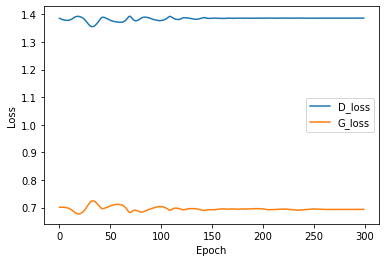

In [ ]:
if __name__ == '__main__':
    input_dim = X_train.shape[1]
    feature_size = X_train.shape[2]
    output_dim = y_train.shape[1]

    ## For Bayesian
    opt = {"lr": 0.00016, "epoch": 300, 'bs': 128}

    generator = make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
    discriminator = make_discriminator_model()
    gan = GAN(generator, discriminator, opt)
    Predicted_price, Real_price, RMSPE = gan.train(X_train, y_train, yc_train, opt)

----- predicted price ----- [[-0.9775581 ]
 [-0.97445047]
 [-0.9780863 ]
 ...
 [-0.9055519 ]
 [-0.9077994 ]
 [-0.90659386]]
----- rescaled predicted price ----- [[18.9622  ]
 [20.865128]
 [18.63875 ]
 ...
 [63.054817]
 [61.678562]
 [62.416782]]
----- SHAPE rescaled predicted price ----- (1746, 1)


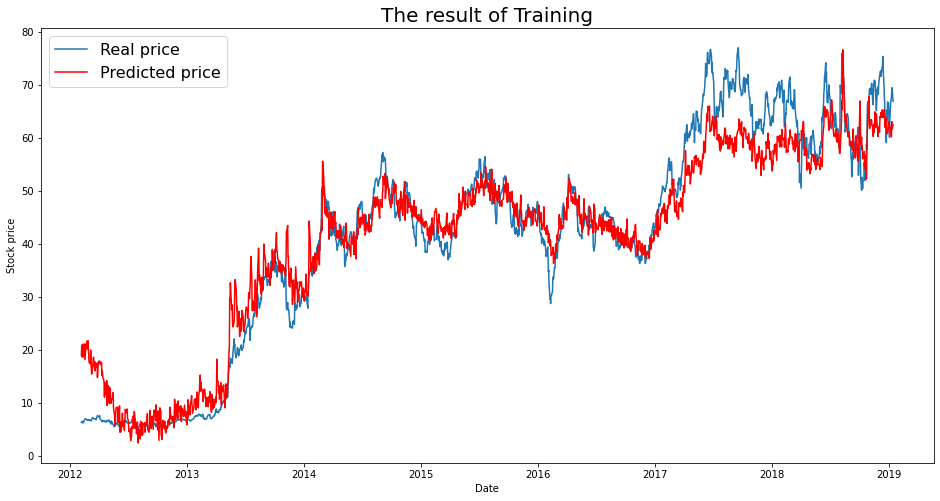

-- Train RMSE --  5.156700792445


In [ ]:
# %% --------------------------------------- Plot the result  -----------------------------------------------------------------

# Rescale back the real dataset
X_scaler = load(open('X_scaler.pkl', 'rb'))
y_scaler = load(open('y_scaler.pkl', 'rb'))
train_predict_index = np.load("train_predict_index.npy", allow_pickle=True)
test_predict_index = np.load("test_predict_index.npy", allow_pickle=True)
#dataset_train = pd.read_csv('dataset_train.csv', index_col=0)


print("----- predicted price -----", Predicted_price)

rescaled_Real_price = y_scaler.inverse_transform(Real_price)
rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

print("----- rescaled predicted price -----", rescaled_Predicted_price)
print("----- SHAPE rescaled predicted price -----", rescaled_Predicted_price.shape)

predict_result = pd.DataFrame()
for i in range(rescaled_Predicted_price.shape[0]):
    y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
    predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

real_price = pd.DataFrame()
for i in range(rescaled_Real_price.shape[0]):
    y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
    real_price = pd.concat([real_price, y_train], axis=1, sort=False)

predict_result['predicted_mean'] = predict_result.mean(axis=1)
real_price['real_mean'] = real_price.mean(axis=1)

# Plot the predicted result
plt.figure(figsize=(16, 8))
plt.plot(real_price["real_mean"])
plt.plot(predict_result["predicted_mean"], color = 'r')
plt.xlabel("Date")
plt.ylabel("Stock price")
plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
plt.title("The result of Training", fontsize=20)
plt.show()

# Calculate RMSE
predicted = predict_result["predicted_mean"]
real = real_price["real_mean"]
For_MSE = pd.concat([predicted, real], axis = 1)
RMSE = np.sqrt(mean_squared_error(predicted, real))
print('-- Train RMSE -- ', RMSE)

In [ ]:
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from pickle import load
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.layers import GRU, LSTM, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, ELU, ReLU
from tensorflow.keras import Sequential, regularizers
from tensorflow.python.client import device_lib

In [ ]:
# Load data
X_train = np.load("X_train.npy", allow_pickle=True)
y_train = np.load("y_train.npy", allow_pickle=True)
X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)
yc_train = np.load("yc_train.npy", allow_pickle=True)
yc_test = np.load("yc_test.npy", allow_pickle=True)

In [ ]:
# Define the generator
def Generator(input_dim, output_dim, feature_size) -> tf.keras.models.Model:
    model = Sequential()
    model.add(LSTM(units=256,
                  return_sequences=True,
                  input_shape=(input_dim, feature_size),
                  recurrent_dropout=0.02,
                  recurrent_regularizer=regularizers.l2(1e-3)))
    model.add(LSTM(units=128,
                  #return_sequences=True,
                  recurrent_dropout=0.02,
                  recurrent_regularizer=regularizers.l2(1e-3)))
    #model.add(Dense(128,
    #              kernel_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(64, kernel_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(32, kernel_regularizer=regularizers.l2(1e-3)))
    #model.add(Dense(16, kernel_regularizer=regularizers.l2(1e-3)))
    #model.add(Dense(8, kernel_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(units=output_dim))
    return model

# Define the discriminator
def Discriminator() -> tf.keras.models.Model:
    model = tf.keras.Sequential()
    model.add(Conv1D(32, input_shape=(4, 1), kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01)))
    model.add(Conv1D(64, kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01)))
    model.add(Conv1D(128, kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01)))
    model.add(Flatten())
    model.add(Dense(220, use_bias=True))
    model.add(LeakyReLU())
    model.add(Dense(220, use_bias=True))
    model.add(ReLU())
    model.add(Dense(1))
    return model

In [ ]:
# Train WGAN-GP model
class GAN():
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.d_optimizer = tf.keras.optimizers.Adam(0.0001)
        self.g_optimizer = tf.keras.optimizers.Adam(0.0001)
        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = 128
        checkpoint_dir = '../training_checkpoints'
        self.checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
        self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.g_optimizer,
                                              discriminator_optimizer=self.d_optimizer,
                                              generator=self.generator,
                                              discriminator=self.discriminator)

    def gradient_penalty(self, batch_size, real_output, fake_output):
        """ Calculates the gradient penalty.
        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # get the interpolated data
        alpha = tf.random.normal([batch_size, 4, 1], 0.0, 1.0)
        diff = fake_output - tf.cast(real_output, tf.float32)
        interpolated = tf.cast(real_output, tf.float32) + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]

        # 3. Calcuate the norm of the gradients
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))

        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        real_input, real_price, yc = data
        batch_size = tf.shape(real_input)[0]
        for _ in range(1):
            with tf.GradientTape() as d_tape:
                # Train the discriminator
                # generate fake output
                generated_data = self.generator(real_input, training=True)
                # reshape the data
                generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
                fake_output = tf.concat([generated_data_reshape, tf.cast(yc, tf.float32)], axis=1)
                real_y_reshape = tf.reshape(real_price, [real_price.shape[0], real_price.shape[1], 1])
                real_output = tf.concat([tf.cast(real_y_reshape, tf.float32), tf.cast(yc, tf.float32)], axis=1)
                # Get the logits for the fake images
                D_real = self.discriminator(real_output, training=True)
                # Get the logits for real images
                D_fake = self.discriminator(fake_output, training=True)
                # Calculate discriminator loss using fake and real logits
                real_loss = tf.cast(tf.reduce_mean(D_real), tf.float32)
                fake_loss = tf.cast(tf.reduce_mean(D_fake), tf.float32)
                d_cost = fake_loss-real_loss
                # Calculate the gradientjiu penalty
                gp = self.gradient_penalty(batch_size, real_output, fake_output)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * 10

            d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))
        for _ in range(3):
            with tf.GradientTape() as g_tape:
                # Train the generator
                # generate fake output
                generated_data = self.generator(real_input, training=True)
                # reshape the data
                generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
                fake_output = tf.concat([generated_data_reshape, tf.cast(yc, tf.float32)], axis=1)
                # Get the discriminator logits for fake images
                G_fake = self.discriminator(fake_output, training=True)
                # Calculate the generator loss
                g_loss = -tf.reduce_mean(G_fake)
            g_grads = g_tape.gradient(g_loss, self.generator.trainable_variables)
            self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return real_price, generated_data, {'d_loss': d_loss, 'g_loss': g_loss}

    def train(self, X_train, y_train, yc, epochs):
        data = X_train, y_train, yc
        train_hist = {}
        train_hist['D_losses'] = []
        train_hist['G_losses'] = []
        train_hist['per_epoch_times'] = []
        train_hist['total_ptime'] = []


        for epoch in range(epochs):
            start = time.time()

            real_price, fake_price, loss = self.train_step(data)

            G_losses = []
            D_losses = []

            Real_price = []
            Predicted_price = []

            D_losses.append(loss['d_loss'].numpy())
            G_losses.append(loss['g_loss'].numpy())

            Predicted_price.append(fake_price)
            Real_price.append(real_price)

            # Save the model every 15 epochs
            if (epoch + 1) % 15 == 0:
                tf.keras.models.save_model(generator, 'WGAN-GP_LSTM_model_%d.h5' % epoch)
                self.checkpoint.save(file_prefix=self.checkpoint_prefix)
                print('epoch', epoch+1, 'd_loss', loss['d_loss'].numpy(), 'g_loss', loss['g_loss'].numpy())

            # For printing loss
            epoch_end_time = time.time()
            per_epoch_ptime = epoch_end_time - start
            train_hist['D_losses'].append(D_losses)
            train_hist['G_losses'].append(G_losses)
            train_hist['per_epoch_times'].append(per_epoch_ptime)
            
        # Reshape the predicted result & real
        Predicted_price = np.array(Predicted_price)
        Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
        Real_price = np.array(Real_price)
        Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

        # Plot the loss
        plt.plot(train_hist['D_losses'], label='D_loss')
        plt.plot(train_hist['G_losses'], label='G_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        plt.savefig('train_loss.png')

        print("REAL", Real_price.shape)
        print(Real_price)
        print("PREDICTED", Predicted_price.shape)
        print(Predicted_price)

        return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)

epoch 15 d_loss 9.094882 g_loss -0.0073696394
epoch 30 d_loss 8.805991 g_loss -0.12192501
epoch 45 d_loss 7.534 g_loss 0.40130058
epoch 60 d_loss 6.726834 g_loss -0.011715199
epoch 75 d_loss 4.754409 g_loss -0.056971963
epoch 90 d_loss 2.9125075 g_loss -0.13175923
epoch 105 d_loss 1.3148336 g_loss -0.22292455
epoch 120 d_loss 0.1786266 g_loss -0.3327626
epoch 135 d_loss 0.040828876 g_loss -0.40511134
epoch 150 d_loss 0.0059520844 g_loss -0.38834515
epoch 165 d_loss 0.0030323865 g_loss -0.37612507
epoch 180 d_loss 0.002092322 g_loss -0.37973163
epoch 195 d_loss 0.0033053989 g_loss -0.37735388
epoch 210 d_loss 0.0025213328 g_loss -0.37232423
epoch 225 d_loss 0.002475488 g_loss -0.37462085
epoch 240 d_loss 0.0024368544 g_loss -0.3760524
epoch 255 d_loss 0.0021478073 g_loss -0.37453762
epoch 270 d_loss 0.0021338342 g_loss -0.37417096
epoch 285 d_loss 0.0020483283 g_loss -0.3742728
epoch 300 d_loss 0.0019235311 g_loss -0.3740584
epoch 315 d_loss 0.0017786032 g_loss -0.3737751
epoch 330 d_lo

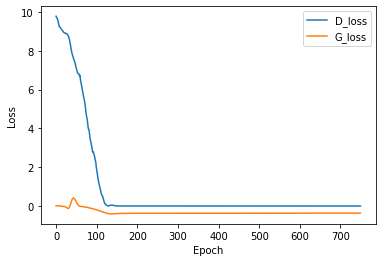

REAL (1746, 1)
[[-0.9981383 ]
 [-0.99820363]
 [-0.99809584]
 ...
 [-0.89585283]
 [-0.89510488]
 [-0.89930514]]
PREDICTED (1746, 1)
[[-0.9950581 ]
 [-0.99754465]
 [-0.99637866]
 ...
 [-0.89565766]
 [-0.8969474 ]
 [-0.89097685]]


<Figure size 432x288 with 0 Axes>

In [ ]:
if __name__ == '__main__':
    input_dim = X_train.shape[1]
    feature_size = X_train.shape[2]
    output_dim = y_train.shape[1]
    epoch = 750

    generator = Generator(X_train.shape[1], output_dim, X_train.shape[2])
    discriminator = Discriminator()
    gan = GAN(generator, discriminator)
    Predicted_price, Real_price, RMSPE = gan.train(X_train, y_train, yc_train, epoch)


----- predicted price ----- [[-0.9950581 ]
 [-0.99754465]
 [-0.99637866]
 ...
 [-0.89565766]
 [-0.8969474 ]
 [-0.89097685]]
----- rescaled predicted price ----- [[ 8.246136 ]
 [ 6.7235236]
 [ 7.4375095]
 ...
 [69.11351  ]
 [68.32375  ]
 [71.97978  ]]
----- SHAPE rescaled predicted price ----- (1746, 1)


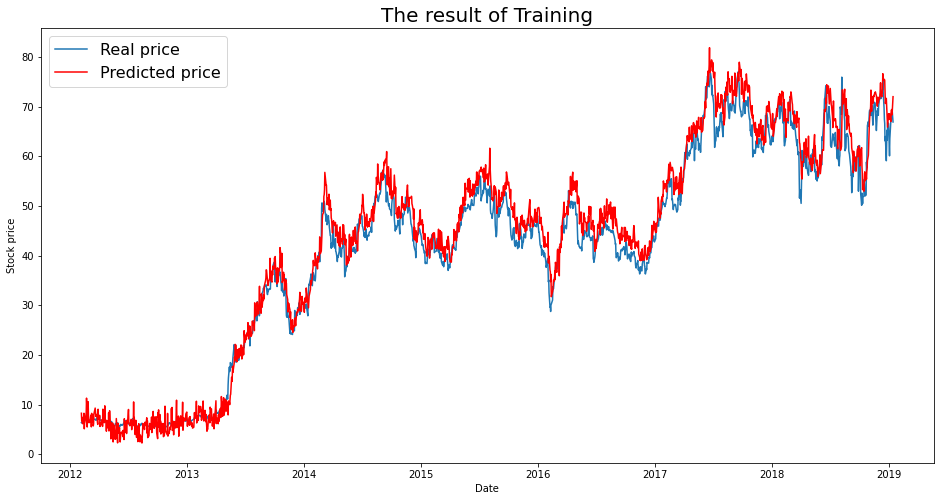

-- RMSE --  3.406759668226393


<Figure size 432x288 with 0 Axes>

In [ ]:
# %% --------------------------------------- Plot the result -----------------------------------------------------

# Rescale back the real dataset
X_scaler = load(open('X_scaler.pkl', 'rb'))
y_scaler = load(open('y_scaler.pkl', 'rb'))
train_predict_index = np.load("index_train.npy", allow_pickle=True)
test_predict_index = np.load("index_test.npy", allow_pickle=True)

print("----- predicted price -----", Predicted_price)

rescaled_Real_price = y_scaler.inverse_transform(Real_price)
rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

print("----- rescaled predicted price -----", rescaled_Predicted_price)
print("----- SHAPE rescaled predicted price -----", rescaled_Predicted_price.shape)

predict_result = pd.DataFrame()
for i in range(rescaled_Predicted_price.shape[0]):
    y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
    predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

real_price = pd.DataFrame()
for i in range(rescaled_Real_price.shape[0]):
    y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
    real_price = pd.concat([real_price, y_train], axis=1, sort=False)

predict_result['predicted_mean'] = predict_result.mean(axis=1)
real_price['real_mean'] = real_price.mean(axis=1)

# # drop 2022
# Input_Before = '2022-01-01'
# predict_result = predict_result.loc[predict_result.index < Input_Before]
# real_price = real_price.loc[real_price.index < Input_Before]

# Plot the predicted result
plt.figure(figsize=(16, 8))
plt.plot(real_price["real_mean"])
plt.plot(predict_result["predicted_mean"], color = 'r')
plt.xlabel("Date")
plt.ylabel("Stock price")
plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
plt.title("The result of Training", fontsize=20)
plt.show()
plt.savefig('train_plot.png')

#Calculate RMSE
predicted = predict_result["predicted_mean"]
real = real_price["real_mean"]
For_MSE = pd.concat([predicted, real], axis = 1)
RMSE = np.sqrt(mean_squared_error(predicted, real))
print('-- RMSE -- ', RMSE)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from pickle import load
from sklearn.metrics import mean_squared_error

In [ ]:
# Load scaler/ index
X_scaler = load(open('X_scaler.pkl', 'rb'))
y_scaler = load(open('y_scaler.pkl', 'rb'))
train_predict_index = np.load("index_train.npy", allow_pickle=True)
test_predict_index = np.load("index_test.npy", allow_pickle=True)

In [ ]:
# Load test dataset/ model
G_model = tf.keras.models.load_model('WGAN-GP_LSTM_model_749.h5')
X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)

In [ ]:
def get_test_plot(X_test, y_test):
    # Set output steps
    output_dim = y_test.shape[1]

    # Get predicted data
    y_predicted = G_model(X_test)
    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(y_predicted)

    ## Predicted price
    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    ## Real price
    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"], index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    # drop 2022
    Input_Before = '2022-01-01'
    predict_result = predict_result.loc[predict_result.index < Input_Before]
    real_price = real_price.loc[real_price.index < Input_Before]

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of test", fontsize=20)
    plt.show()
    plt.savefig('test_plot.png')
    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis=1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- RMSE -- ', RMSE)

    return predict_result, RMSE

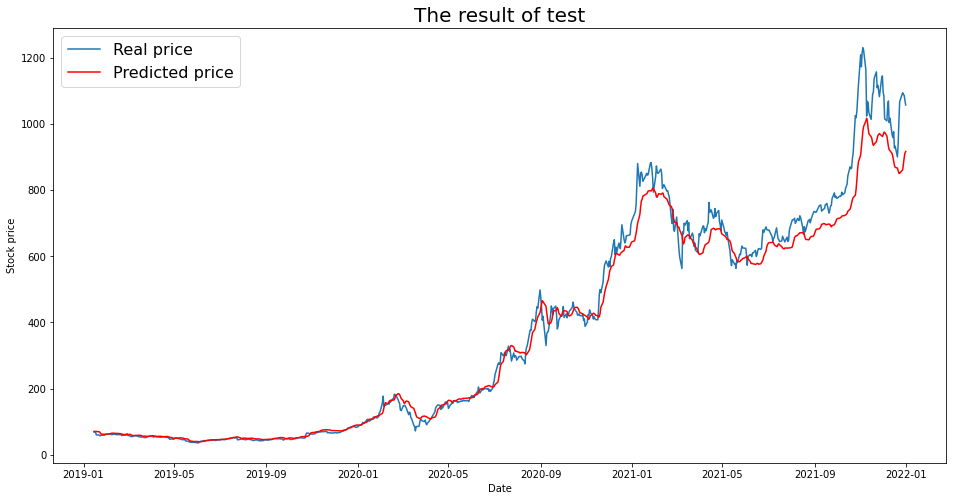

-- RMSE --  52.73939790035923


<Figure size 432x288 with 0 Axes>

In [ ]:
test_predicted, test_RMSE = get_test_plot(X_test, y_test)
test_predicted.to_csv("test_predicted.csv")